In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def softmax(x):
    x = x - x.max(axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

def runTrial(v, fixatedAlternatives, fixatedAttributes,
             leak, inhibition, integration,
             lam, theta, eta, phi, w0, contrast, beta,
             custom_S=None,
             verbose=True, plot=True):

    nItems, nAttributes = v.shape

    nFixations = len(fixatedAlternatives)

    X = np.zeros((nFixations + 1, nItems))

    if contrast:
        C = np.ones((nItems, nItems)) * (-1 / (nItems - 1))
        np.fill_diagonal(C, 1)
    else:
        C = np.eye(nItems)

    if custom_S is not None and verbose:
        print("Custom feedback matrix S provided. Ignoring setting and parameters for leak and inhibition.")
        
    for f, (alt, att) in enumerate(
        zip(fixatedAlternatives, fixatedAttributes)):

        # Leak
        if leak == 'none':
            lam_v = np.ones(nItems)
        elif leak == 'constant':
            lam_v = np.ones(nItems) * lam
        elif leak == 'gaze':
            lam_v = np.ones(nItems) * lam
            lam_v[alt] = 1
        else:
            raise ValueError(f"Leak must be 'none', 'constant' or 'gaze' (is '{leak}').")

        # Inhibition
        if inhibition == 'none':
            phi_m = np.zeros((nItems, nItems))
        elif inhibition == 'constant':
            phi_m = np.ones((nItems, nItems)) * -phi
            np.fill_diagonal(phi_m, 0)
        elif inhibition == 'gaze':
            phi_m = np.zeros((nItems, nItems))
            phi_m[:, alt] = -phi
            np.fill_diagonal(phi_m, 0)
        elif inhibition == 'distance':
            phi_m = euclidean_distances(v)
            phi_m /= phi_m.max()
            phi_m *= -phi
            np.fill_diagonal(phi_m, 0)
        else:
            raise ValueError(f"Inhibition must be 'none', 'constant', 'distance' or 'gaze' (is '{inhibition}').")
        
        # Alt-wise gaze-discount
        theta_v = np.ones(nItems) * theta
        theta_v[alt] = 1
        
        # Att-wise gaze-discount
        eta_v = np.ones(nAttributes) * eta
        eta_v[att] = 1
        
        # Combine leak and inhibition into feedback matrix
        S  = phi_m + np.diag(lam_v)
        if custom_S is not None:
            S = custom_S            
        
        # Attribute integration
        w = np.array([w0, 1 - w0])
        if integration == 'additive':
            vInt = np.sum(w * eta_v * theta_v[:, None] * v, axis=1)
        elif integration == 'multiplicative':
            vInt = np.product(w * eta_v * theta_v[:, None] * v, axis=1)
        else:
            raise ValueError(f"Integration must be 'additive' or 'multiplicative' (is '{integration}').")
        
        dX = C.dot(vInt)
        X[f + 1] = S.dot(X[f]) + dX
        if verbose:
            print(f'{f}\tdX: {dX}\tX: {X[f+1].round(2)}')

            
    CP = softmax(beta * X[-1, :])
    if verbose:
        print(f'CP: {CP.round(8)}')
            
    if plot:
        plt.plot(X)
        plt.xlabel('Fixations')
        plt.ylabel('X')
        plt.show()

    return X, CP

In [4]:
v = np.array([[1, 2],
              [2, 1],
              [3, 0]])

fixatedAlternatives = [0, 1, 2, 2, 1, 0]
fixatedAttributes   = [0, 1, 0, 1, 1, 0]

leak        = 'constant'  # [none, constant, gaze]
inhibition  = 'none'  # [none, constant, gaze, (distance)]
integration = 'additive'  # [additive, multiplicative]

lam = 0.9      # Fixation-dependent leak (1 = no leak, 0 = full leak for non-fixated alternatives)
theta = 0.3  # Alternative-wise gaze-discount 
eta = 0.3    # Attribute-wise gaze-discount
phi = 0.1    # Inhibition parameter (0 = no inhibition, 1 = inhibition of current magnitude)
w0 = 0.3     # Relative weight of attribute 0

0	dX: [0.72  0.243 0.27 ]	X: [0.72 0.24 0.27]
1	dX: [0.447 0.88  0.081]	X: [1.1  1.1  0.32]
2	dX: [0.216 0.243 0.9  ]	X: [1.2  1.23 1.19]
3	dX: [0.447 0.264 0.27 ]	X: [1.53 1.37 1.34]
4	dX: [0.447 0.88  0.081]	X: [1.82 2.12 1.29]
5	dX: [0.72  0.243 0.27 ]	X: [2.36 2.15 1.43]
CP: [0.5530223  0.36088504 0.08609266]


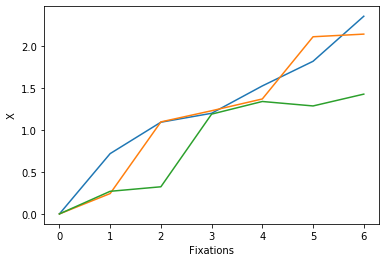

In [5]:
betaContrastFalse = 2
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=False,
    beta=betaContrastFalse,
);

0	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.46 -0.25 -0.21]
1	dX: [-0.0335  0.616  -0.5825]	X: [ 0.38  0.39 -0.77]
2	dX: [-0.3555 -0.315   0.6705]	X: [-0.01  0.04 -0.03]
3	dX: [ 0.18   -0.0945 -0.0855]	X: [ 0.17 -0.06 -0.11]
4	dX: [-0.0335  0.616  -0.5825]	X: [ 0.12  0.56 -0.68]
5	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.57  0.25 -0.82]
CP: [0.5530223  0.36088504 0.08609266]


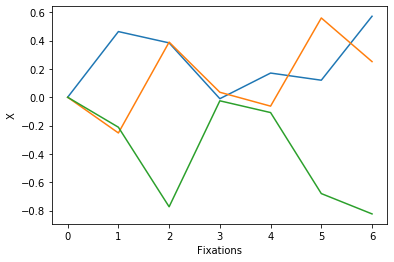

In [6]:
nItems, nAttributes = v.shape
betaContrastTrue = betaContrastFalse * (nItems - 1) / (nItems)
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=True,
    beta=betaContrastTrue,
);

Once again, this illustrates that the contrast and no-contrast versions are equivalent for cases with a constant feedback matrix $S$ over time. The equivalence breaks, as soon as either the leak or feedback mechanisms (diagonal and off-diagonal elements of the feedback matrix) are made to depend on gaze.

# What about non-uniform, symmetric feedback?

In [7]:
S = euclidean_distances(v)
S /= -S.max()
S *= 0.1
np.fill_diagonal(S, lam)
S

array([[ 0.9 , -0.05, -0.1 ],
       [-0.05,  0.9 , -0.05],
       [-0.1 , -0.05,  0.9 ]])

Custom feedback matrix S provided. Ignoring setting and parameters for leak and inhibition.
0	dX: [0.72  0.243 0.27 ]	X: [0.72 0.24 0.27]
1	dX: [0.447 0.88  0.081]	X: [1.06 1.05 0.24]
2	dX: [0.216 0.243 0.9  ]	X: [1.09 1.12 0.96]
3	dX: [0.447 0.264 0.27 ]	X: [1.28 1.17 0.97]
4	dX: [0.447 0.88  0.081]	X: [1.44 1.82 0.77]
5	dX: [0.72  0.243 0.27 ]	X: [1.85 1.77 0.72]
CP: [0.50879263 0.43758102 0.05362635]


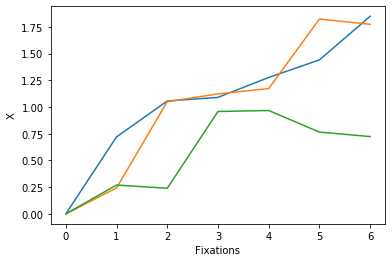

In [8]:
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=False,
    beta=betaContrastFalse,
    custom_S=S
);

Custom feedback matrix S provided. Ignoring setting and parameters for leak and inhibition.
0	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.46 -0.25 -0.21]
1	dX: [-0.0335  0.616  -0.5825]	X: [ 0.42  0.38 -0.81]
2	dX: [-0.3555 -0.315   0.6705]	X: [ 0.08  0.04 -0.12]
3	dX: [ 0.18   -0.0945 -0.0855]	X: [ 0.26 -0.05 -0.2 ]
4	dX: [-0.0335  0.616  -0.5825]	X: [ 0.23  0.56 -0.79]
5	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.72  0.28 -0.97]
CP: [0.60005293 0.33670196 0.06324511]


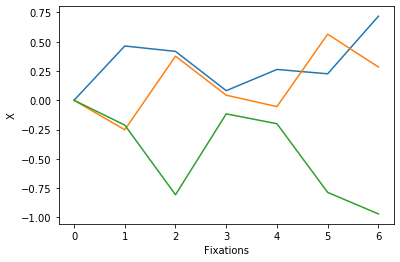

In [9]:
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=True,
    beta=betaContrastTrue,
    custom_S=S
);

That's enough to break the equivalence.

# What about non-uniform leak?

In [10]:
S = np.diag([0.9, 0.7, 0.7])
S

array([[0.9, 0. , 0. ],
       [0. , 0.7, 0. ],
       [0. , 0. , 0.7]])

Custom feedback matrix S provided. Ignoring setting and parameters for leak and inhibition.
0	dX: [0.72  0.243 0.27 ]	X: [0.72 0.24 0.27]
1	dX: [0.447 0.88  0.081]	X: [1.1  1.05 0.27]
2	dX: [0.216 0.243 0.9  ]	X: [1.2  0.98 1.09]
3	dX: [0.447 0.264 0.27 ]	X: [1.53 0.95 1.03]
4	dX: [0.447 0.88  0.081]	X: [1.82 1.54 0.8 ]
5	dX: [0.72  0.243 0.27 ]	X: [2.36 1.32 0.83]
CP: [0.85256799 0.10727568 0.04015633]


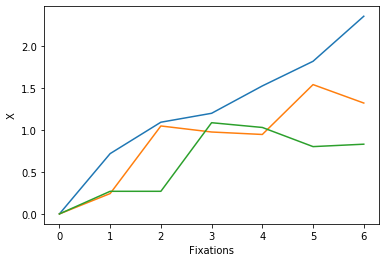

In [11]:
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=False,
    beta=betaContrastFalse,
    custom_S=S
);

Custom feedback matrix S provided. Ignoring setting and parameters for leak and inhibition.
0	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.46 -0.25 -0.21]
1	dX: [-0.0335  0.616  -0.5825]	X: [ 0.38  0.44 -0.73]
2	dX: [-0.3555 -0.315   0.6705]	X: [-0.01 -0.01  0.16]
3	dX: [ 0.18   -0.0945 -0.0855]	X: [ 0.17 -0.1   0.03]
4	dX: [-0.0335  0.616  -0.5825]	X: [ 0.12  0.55 -0.56]
5	dX: [ 0.4635 -0.252  -0.2115]	X: [ 0.57  0.13 -0.61]
CP: [0.5672014  0.31491645 0.11788214]


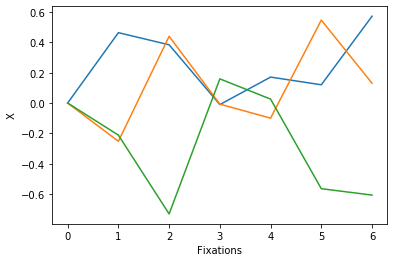

In [12]:
runTrial(
    v=v,
    fixatedAlternatives=fixatedAlternatives,
    fixatedAttributes=fixatedAttributes,
    leak=leak,
    inhibition=inhibition,
    integration=integration,
    lam=lam,
    theta=theta,
    eta=eta,
    phi=phi,
    w0=w0,
    contrast=True,
    beta=betaContrastTrue,
    custom_S=S
);

This also causes differences between independent and comparative accumulation.

# Systematic investigation:

I have demonstrated that two variants can be equivalent if their feedback matrices have the general form

$$
\begin{equation*}
S_{m,n} = 
\begin{pmatrix}
\lambda & -\phi & \cdots & -\phi \\
-\phi & \lambda & \cdots & -\phi \\
\vdots  & \vdots  & \ddots & \vdots  \\
-\phi & -\phi & \cdots & \lambda 
\end{pmatrix}
\end{equation*}
$$

This is the case for all combinations of `none` and `constant` inhibition and leak, and generally violated when either of these switches is gaze- or distance-dependent.

To complete the picture and summarise these results, I will now systematically predict choice probabilities from all possible model variants and test whether the choice probabilities (with adjusted $\beta$ parameter) match between independent and comparative variants:

In [13]:
v = np.array([[1, 2], [2, 1], [3, 0]])

nItems, nAttributes = v.shape

theta_if_used = 0.3
eta_if_used = 0.3
lam = 0.9
phi = 0.1
betaContrastFalse = 2
betaContrastTrue = betaContrastFalse * (nItems - 1) / (nItems)

results = []

integration = "multiplicative"
w0 = 0.5

for leak in ["none", "constant", "gaze"]:
    for inhibition in ["none", "constant", "gaze", "distance"]:
        for theta, gd_alt in zip([theta_if_used, 1], [True, False]):
            for eta, gd_att in zip([eta_if_used, 1], [True, False]):
                result = {}
                for contrast, beta in zip(
                    [True, False], [betaContrastTrue, betaContrastFalse]
                ):
                    X, CP = runTrial(
                        v=v,
                        fixatedAlternatives=fixatedAlternatives,
                        fixatedAttributes=fixatedAttributes,
                        leak=leak,
                        inhibition=inhibition,
                        integration=integration,
                        lam=lam,
                        theta=theta,
                        eta=eta,
                        phi=phi,
                        w0=w0,
                        contrast=contrast,
                        beta=beta,
                        verbose=False,
                        plot=False,
                    )
                    result[contrast] = pd.DataFrame(
                        dict(
                            contrast=contrast,
                            leak=leak,
                            inhibition=inhibition,
                            integration=integration,
                            gd_alt=gd_alt,
                            gd_att=gd_att,
                        ),
                        index=[0],
                    )
                    result[contrast]["cp0"] = CP[0].round(4)
                    result[contrast]["cp1"] = CP[1].round(4)
                    result[contrast]["cp2"] = CP[2].round(4)

                # Comparison
                cpTrue = np.array(
                    [result[True][f"cp{i}"].values[0] for i in range(nItems)]
                )
                cpFalse = np.array(
                    [result[False][f"cp{i}"].values[0] for i in range(nItems)]
                )
                equivalent = np.all(cpTrue == cpFalse)
                result[True]["equivalent"] = equivalent
                result[False]["equivalent"] = equivalent
                results.append(result[True])
                results.append(result[False])


results = pd.concat(results).reset_index(drop=True)

In [14]:
results.head()

,contrast,leak,inhibition,integration,gd_alt,gd_att,cp0,cp1,cp2,equivalent
0,True,none,none,multiplicative,True,True,0.4012,0.4012,0.1976,True
1,False,none,none,multiplicative,True,True,0.4012,0.4012,0.1976,True
2,True,none,none,multiplicative,True,False,0.4775,0.4775,0.0451,True
3,False,none,none,multiplicative,True,False,0.4775,0.4775,0.0451,True
4,True,none,none,multiplicative,False,True,0.4618,0.4618,0.0763,True


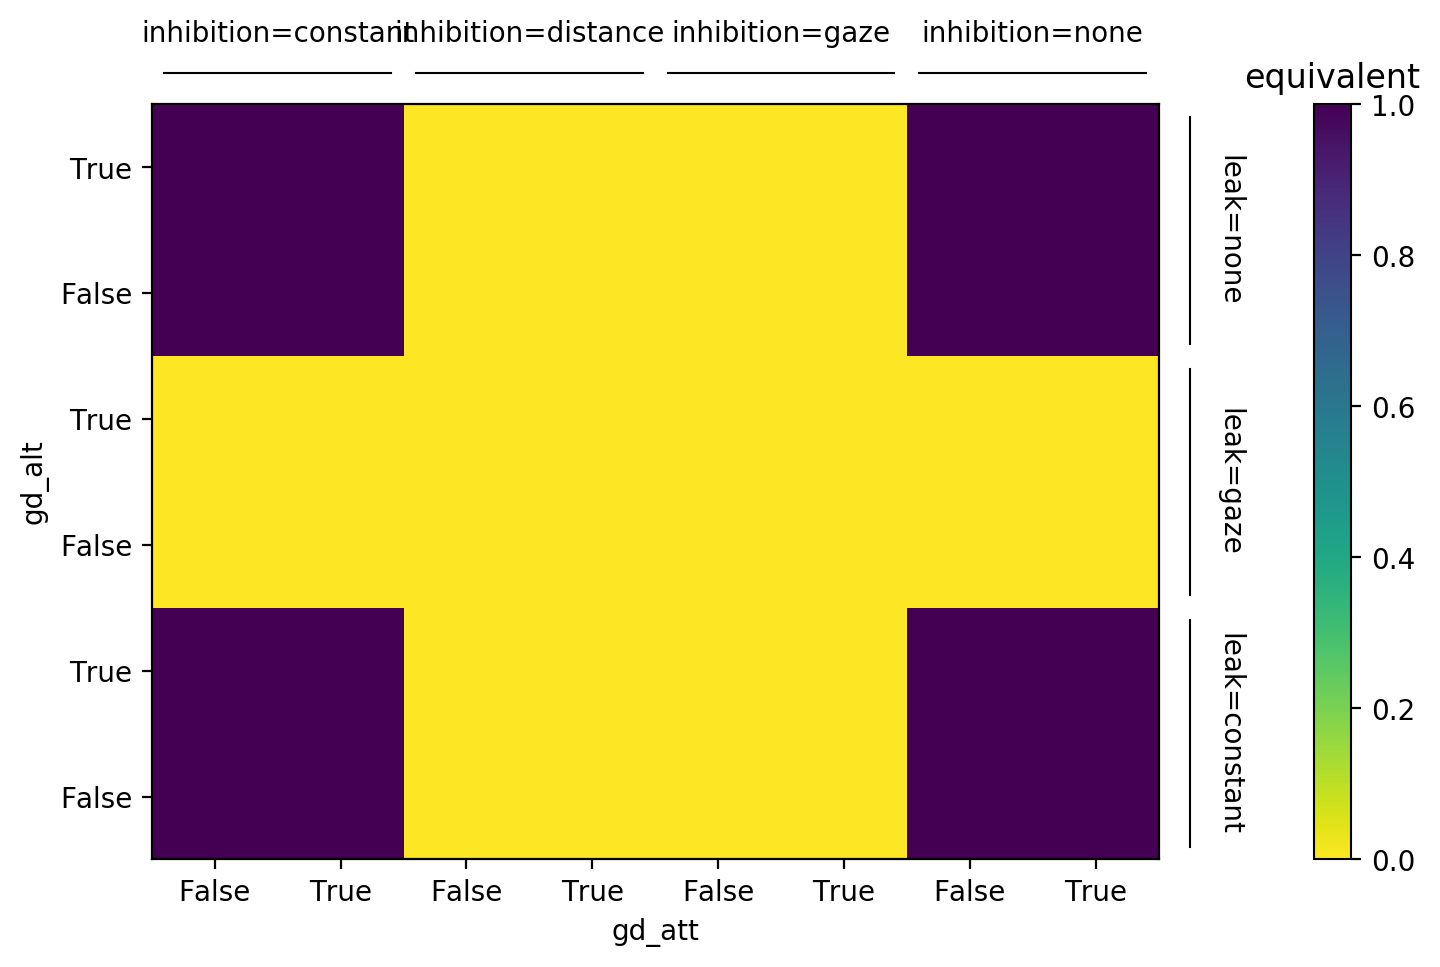

In [15]:
from plot_share import factorial_heatmap

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

df = results.loc[results['contrast']].copy()
df['equivalent'] = df['equivalent'].astype(float)
factorial_heatmap(df,
                  row_factors=['leak', 'gd_alt'],
                  col_factors=['inhibition', 'gd_att'],
                  value_var='equivalent',
                  ax=ax);

## Summary

The cases identified before remain the only ones, for which equivalence between independent and comparative accumulation holds.

Whenever the feedback matrix $S$ does not have the form

$$
\begin{equation*}
S_{m,n} = 
\begin{pmatrix}
\lambda & -\phi & \cdots & -\phi \\
-\phi & \lambda & \cdots & -\phi \\
\vdots  & \vdots  & \ddots & \vdots  \\
-\phi & -\phi & \cdots & \lambda 
\end{pmatrix}
\end{equation*}
$$

throughout the trial, equivalence is broken.
The attribute- and alternative-wise gaze-discount mechanisms do not affect the equivalence at all.